# Time Series Prediction with LSTM Recurrent Neural Networks with Keras

Time series prediction problems are a difficult type of predictive modeling problem.

Unlike regression predictive modeling, time series adds the complexity of a sequence dependence among the input variables.

A powerful type of neural network designed to handle sequence dependence is called recurrent neural networks. The Long Short-Term Memory network or LSTM network is a type of recurrent neural network used in deep learning because very large architectures can be successfully trained.

Here you will discover how to develop LSTM networks in Python using the Keras deep learning library to address a demonstration time-series prediction problem.

By the end you will know how to implement and develop LSTM networks for your own time series prediction problems and other more general sequence problems. You will know:

- About the International Airline Passengers time-series prediction problem.
- How to develop LSTM networks for regression, window and time-step based framing of time series prediction problems?
- How to develop and make predictions using LSTM networks that maintain state (memory) across very long sequences?

Here we will develop a number of LSTMs for a standard time series prediction problem.

## Problem Description

The problem we are going to look at in this post is theInternational Airline Passengers prediction problem.

This is a problem where, given a year and a month, the task is to predict the number of international airline passengers in units of 1,000. The data ranges from January 1949 to December 1960, or 12 years, with 144 observations.

The dataset is available for free from the [DataMarket webpage](https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line) as a CSV download with the filename “international-airline-passengers.csv“.

Below is a sample of the first few lines of the file.

<pre>
"Month","International airline passengers: monthly totals in thousands. Jan 49 - Dec 60"
"1949-01",112
"1949-02",118
"1949-03",132
"1949-04",129
"1949-05",121
</pre>

We can load this dataset easily using the Pandas library. We are not interested in the date, given that each observation is separated by the same interval of one month. Therefore, when we load the dataset we can exclude the first column.

The downloaded dataset also has footer information that we can exclude with the skipfooter argument to pandas.read_csv() set to 3 for the 3 footer lines. Once loaded we can easily plot the whole dataset. The code to load and plot the dataset is listed below.

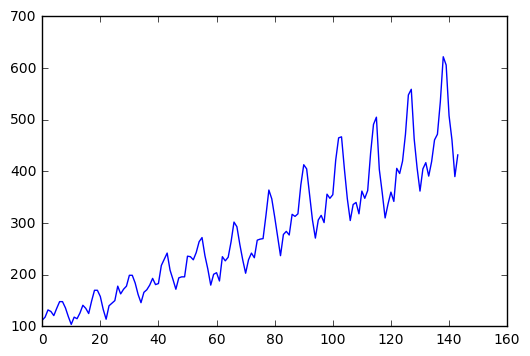

In [2]:
import pandas
import matplotlib.pyplot as plt
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

You can see an upward trend in the dataset over time.

You can also see some periodicity to the dataset that probably corresponds to the Northern Hemisphere vacation period.

## Long Short-Term Memory Network

The Long Short-Term Memory network, or LSTM network, is a recurrent neural network that is trained using Backpropagation Through Time and overcomes the vanishing gradient problem.

As such, it can be used to create large recurrent networks that in turn can be used to address difficult sequence problems in machine learning and achieve state-of-the-art results.

Instead of neurons, LSTM networks have memory blocks that are connected through layers.

A block has components that make it smarter than a classical neuron and a memory for recent sequences. A block contains gates that manage the block’s state and output. A block operates upon an input sequence and each gate within a block uses the sigmoid activation units to control whether they are triggered or not, making the change of state and addition of information flowing through the block conditional.

There are three types of gates within a unit:

- **Forget Gate:** conditionally decides what information to throw away from the block.
- **Input Gate:** conditionally decides which values from the input to update the memory state.
- **Output Gate:** conditionally decides what to output based on input and the memory of the block.

Each unit is like a mini-state machine where the gates of the units have weights that are learned during the training procedure.

You can see how you may achieve sophisticated learning and memory from a layer of LSTMs, and it is not hard to imagine how higher-order abstractions may be layered with multiple such layers.

## LSTM Network for Regression

We can phrase the problem as a regression problem.

That is, given the number of passengers (in units of thousands) this month, what is the number of passengers next month?

We can write a simple function to convert our single column of data into a two-column dataset: the first column containing this month’s (t) passenger count and the second column containing next month’s (t+1) passenger count, to be predicted.

In [3]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# fix random seed for reproducibility
numpy.random.seed(7)

# load the dataset
dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

Using TensorFlow backend.


LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library.

In [4]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

After we model our data and estimate the skill of our model on the training dataset, we need to get an idea of the skill of the model on new unseen data. For a normal classification or regression problem, we would do this using cross validation.

With time series data, the sequence of values is important. A simple method that we can use is to split the ordered dataset into train and test datasets. The code below calculates the index of the split point and separates the data into the training datasets with 67% of the observations that we can use to train our model, leaving the remaining 33% for testing the model.

In [5]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

(96, 48)


Now we can define a function to create a new dataset, as described above.

The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period — in this case defaulted to 1.

This default will create a dataset where X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).

It can be configured, and we will by constructing a differently shaped dataset in the next section.

In [6]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

Let us take a look at the effect of this function on the first rows of the dataset (shown in the unnormalized form for clarity).

<pre>
 X		  Y
112		118
118		132
132		129
129		121
121		135
</pre>

If you compare these first 5 rows to the original dataset sample listed in the previous section, you can see the X=t and Y=t+1 pattern in the numbers.

Let’s use this function to prepare the train and test datasets for modeling.

In [7]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].

Currently, our data is in the form: [samples, features] and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows:

In [8]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

We are now ready to design and fit our LSTM network for this problem.

The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.

In [10]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_dim=look_back))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=0)

Once the model is fit, we can estimate the performance of the model on the train and test datasets. This will give us a point of comparison for new models.

Note that we invert the predictions before calculating error scores to ensure that performance is reported in the same units as the original data (thousands of passengers per month).

In [11]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 23.44 RMSE
Test Score: 58.27 RMSE


We can see that the model has an average error of about 23 passengers (in thousands) on the training dataset, and about 58 passengers (in thousands) on the test dataset. Not that bad.

Finally, we can generate predictions using the model for both the train and test dataset to get a visual indication of the skill of the model.

Because of how the dataset was prepared, we must shift the predictions so that they align on the x-axis with the original dataset. Once prepared, the data is plotted, showing the original dataset in blue, the predictions for the training dataset in green, and the predictions on the unseen test dataset in red.

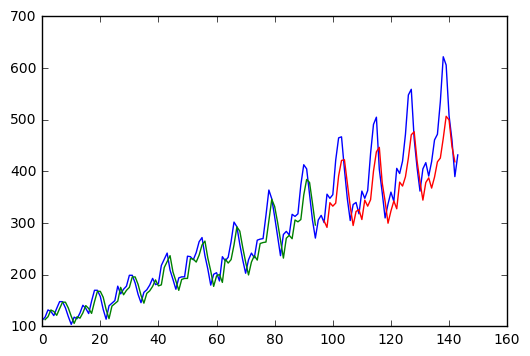

In [12]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

We can see that the model did an excellent job of fitting both the training and the test datasets.

## LSTM for Regression Using the Window Method

We can also phrase the problem so that multiple, recent time steps can be used to make the prediction for the next time step.

This is called a window, and the size of the window is a parameter that can be tuned for each problem.

For example, given the current time (t) we want to predict the value at the next time in the sequence (t+1), we can use the current time (t), as well as the two prior times (t-1 and t-2) as input variables.

When phrased as a regression problem, the input variables are t-2, t-1, t and the output variable is t+1.

The create_dataset() function we created in the previous section allows us to create this formulation of the time series problem by increasing the look_back argument from 1 to 3.

A sample of the dataset with this formulation looks as follows:

<pre>
 X1	 X2	 X3	 Y
112	118	132	129
118	132	129	121
132	129	121	135
129	121	135	148
121	135	148	148
</pre>

We can re-run the example in the previous section with the larger window size. The whole code listing with just the window size change is listed below for completeness.

Train Score: 22.01 RMSE
Test Score: 68.70 RMSE


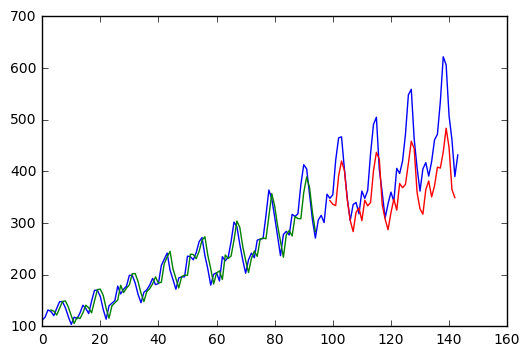

In [13]:
# LSTM for international airline passengers problem with window regression framing
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(7)

# load the dataset
dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_dim=look_back))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=0)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

We can see that the error was increased slightly compared to that of the previous section. The window size and the network architecture were not tuned: this is just a demonstration of how to frame a prediction problem.

## LSTM for Regression with Time Steps

You may have noticed that the data preparation for the LSTM network includes time steps.

Some sequence problems may have a varied number of time steps per sample. For example, you may have measurements of a physical machine leading up to a point of failure or a point of surge. Each incident would be a sample the observations that lead up to the event would be the time steps, and the variables observed would be the features.

Time steps provide another way to phrase our time series problem. Like above in the window example, we can take prior time steps in our time series as inputs to predict the output at the next time step.

Instead of phrasing the past observations as separate input features, we can use them as time steps of the one input feature, which is indeed a more accurate framing of the problem.

We can do this using the same data representation as in the previous window-based example, except when we reshape the data, we set the columns to be the time steps dimension and change the features dimension back to 1. For example:

<pre>
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
</pre>

The entire code listing is provided below for completeness.

Train Score: 23.21 RMSE
Test Score: 57.32 RMSE


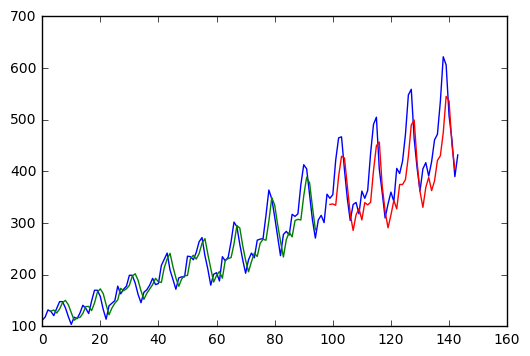

In [16]:
# LSTM for international airline passengers problem with time step regression framing
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(7)

# load the dataset
dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_dim=1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=0)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

We can see that the results are slightly better than previous example, although the structure of the input data makes a lot more sense.

## LSTM with Memory Between Batches

The LSTM network has memory, which is capable of remembering across long sequences.

Normally, the state within the network is reset after each training batch when fitting the model, as well as each call to model.predict() or model.evaluate().

We can gain finer control over when the internal state of the LSTM network is cleared in Keras by making the LSTM layer “stateful”. This means that it can build state over the entire training sequence and even maintain that state if needed to make predictions.

It requires that the training data not be shuffled when fitting the network. It also requires explicit resetting of the network state after each exposure to the training data (epoch) by calls to model.reset_states(). This means that we must create our own outer loop of epochs and within each epoch call model.fit() and model.reset_states(). For example:

<pre>
for i in range(100):
    model.fit(trainX, trainY, nb_epoch=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()
</pre>

Finally, when the LSTM layer is constructed, the stateful parameter must be set True and instead of specifying the input dimensions, we must hard code the number of samples in a batch, number of time steps in a sample and number of features in a time step by setting the batch_input_shape parameter. For example:

<pre>
model.add(LSTM(4, batch_input_shape=(batch_size, time_steps, features), stateful=True))
</pre>

This same batch size must then be used later when evaluating the model and making predictions. For example:

<pre>
model.predict(trainX, batch_size=batch_size)
</pre>

We can adapt the previous time step example to use a stateful LSTM. The full code listing is provided below.

Train Score: 22.17 RMSE
Test Score: 71.53 RMSE


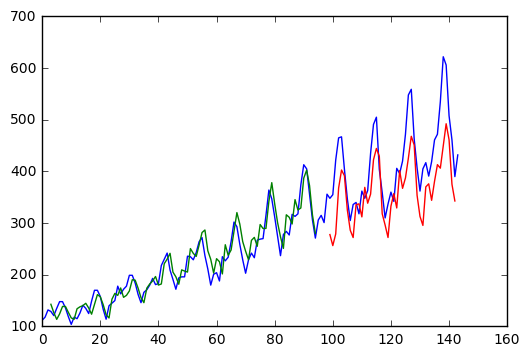

In [19]:
# LSTM for international airline passengers problem with memory
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(7)

# load the dataset
dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
    model.fit(trainX, trainY, nb_epoch=1, batch_size=batch_size, verbose=0, shuffle=False)
    model.reset_states()
    
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

We do see that results are worse. The model may need more modules and may need to be trained for more epochs to internalize the structure of thee problem.

## Stacked LSTMs with Memory Between Batches

Finally, we will take a look at one of the big benefits of LSTMs: the fact that they can be successfully trained when stacked into deep network architectures.

LSTM networks can be stacked in Keras in the same way that other layer types can be stacked. One addition to the configuration that is required is that an LSTM layer prior to each subsequent LSTM layer must return the sequence. This can be done by setting the return_sequences parameter on the layer to True.

We can extend the stateful LSTM in the previous section to have two layers, as follows:

<pre>
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
</pre>

The entire code listing is provided below for completeness.

Train Score: 27.60 RMSE
Test Score: 90.21 RMSE


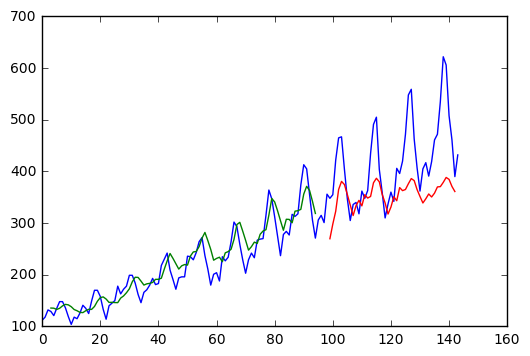

In [22]:
# Stacked LSTM for international airline passengers problem with memory
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(7)

# load the dataset
dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
    model.fit(trainX, trainY, nb_epoch=1, batch_size=batch_size, verbose=0, shuffle=False)
    model.reset_states()
    
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

The predictions on the test dataset are again worse. This is more evidence to suggest the need for additional training epochs.